# ***CIFAR-100 PYTHON DATASET***
> ***We'll try to put on this data on a FEEDFORWARD neural network first before a CNN to see how the results come out!***

In [1]:
from datetime import datetime
now = datetime.now()
formatted = now.strftime("%Y-%m-%d %H:%M:%S")
print("This notebook was last run on - :", formatted)

This notebook was last run on - : 2025-08-13 19:07:01


## **LOADING THE DATASET**

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# First converting them to tensors
transform_to_tensor = transforms.ToTensor()

# Loading the train dataset
train_dataset = datasets.CIFAR10(root="./data",
                                 train=True,
                                 download=True,
                                 transform=transform_to_tensor)
# Loading the test dataset
test_dataset = datasets.CIFAR10(root="./data",
                                train=False,
                                download=True,
                                transform=transform_to_tensor)

100%|██████████| 170M/170M [00:08<00:00, 20.3MB/s]


In [4]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

## **VISUALIZING THE DATASET**

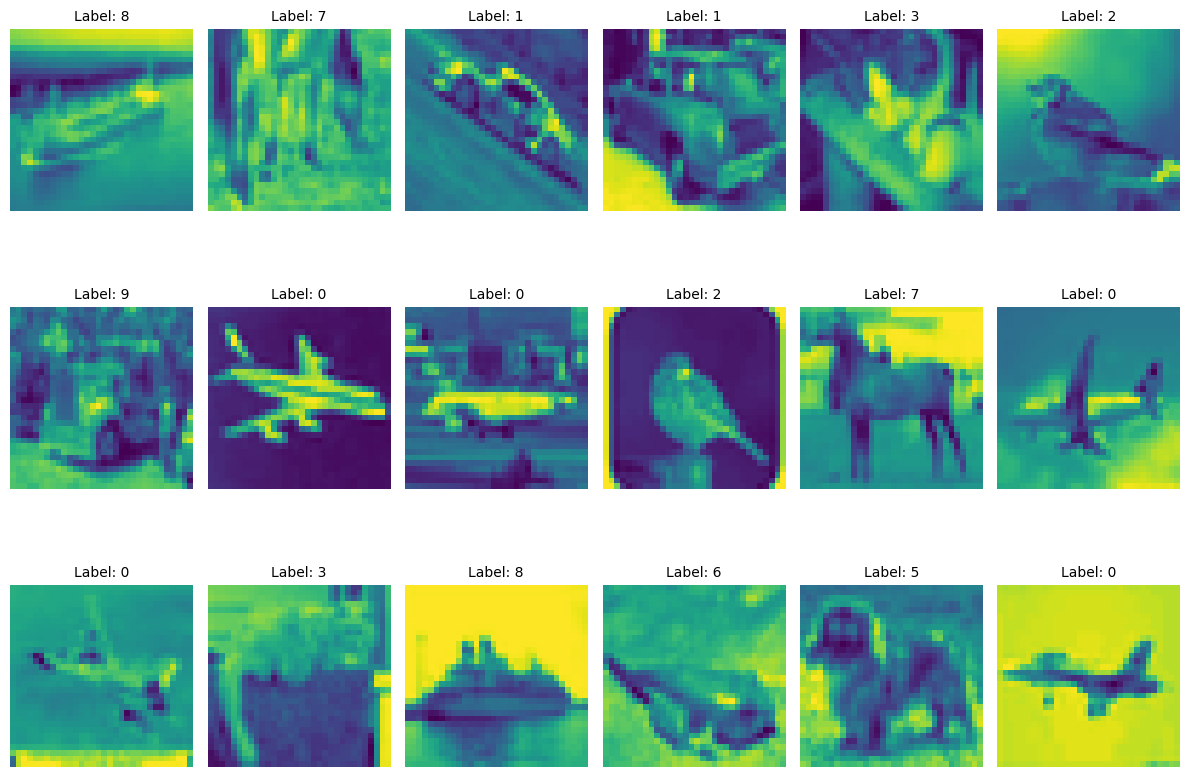

In [6]:
def show_samples(dataset=train_dataset, num_samples=6):
    data_loader = DataLoader(dataset, batch_size=num_samples * 3, shuffle=True)  # 18 images total
    data_loaded, labels_loaded = next(iter(data_loader))

    plt.figure(figsize=(12, 9))
    for idx in range(num_samples * 3):
        plt.subplot(3, num_samples, idx + 1)
        plt.imshow(data_loaded[idx][0])
        plt.title(f"Label: {labels_loaded[idx].item()}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples()


## **MODELLING ON DATA**

In [7]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)
print(f"The length of train - {len(train_loader)*batch_size} and that of test - {len(test_loader)*batch_size}")

The length of train - 50016 and that of test - 10016


In [8]:
num_labels = len(train_dataset.classes)
labels_list = train_dataset.classes

print("Number of labels:", num_labels)
print("Labels:", labels_list)

Number of labels: 10
Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### ***MODEL 0 - BASELINE FEEDFORWARD NEURAL NETWORK MODEL***
**PYTORCH NEURAL NETWORK / GRAPH WORKFLOW**
1. First we define the model class. This is just the model. Then further we can instantiate the model objects.
2. After that we set up the optimizers and the loss function.
3. We also setup the accuracy calculation function.
4. The above 2 functions we made are used in our custom made training loop. After defining the model we need to define it's training loop separately to preserve `PYTORCH WORKFLOW / MODULARITY / CLARITY`
5. Same we do for the testing loop.
6. Now the training and testing loop is only defined, we then run them for `n` epochs. We do something like train -> test -> train -> test ..... so as to `TRACK PROGRESS / EARLY STOPPING IF REQUIRED / HYPERPARAMETER TUNING`.
7. And hence our model becomes completely ready.

**CODE EXPLANATION:**
1. `class NeuralNetwork(nn.Module)` - We create a NeuralNetwork class which inherits from nn.Module - the base class for neural networks
2. `super(<className>, self).__init__()` - This line initializes the parent class (nn.Module). It's required to make the custom model work with PyTorch internals like .parameters(), .to(), .eval() etc.
3. `self.hiddenLayer1 = nn.Linear(28*28, 512)` - This creates a fully connected (dense) layer that maps a 784-dimensional input (28×28) to a 512-dimensional hidden layer.
> Input image → flatten → feed 784 numbers → 512 output values from neurons
4. `self.outputLayer = nn.Linear(512, 10)` - This maps the 512 hidden features to 10 output neurons, each representing a digit (0–9). So the final output is a logit vector of size 10.
5. `X = X.view(-1, 28*28)` - This flattens the 2D image (shape [batch_size, 1, 28, 28]) into a 1D vector [batch_size, 784]. The -1 lets PyTorch infer the batch size dynamically. ***nn expects 1D vectors not 2D images***
6. `X = nn.functional.relu(self.hiddenLayer1(X))` - Here we insert the value we get from the hidden layers into the hidden layer activation functions. In this case relu
7. `X = self.outputLayer(X)` - No activation applied right now as output activations like softmax or sigmoid are often added during loss computation

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
## Let's build the model
torch.manual_seed(42)
input_size = 3*32*32 # 3 channel rgb
hidden_layer_neurons1 = 528
hidden_layer_neurons2 = 256
hidden_layer_neurons3 = 724
num_classes = 10

class NeuralNetwork1(nn.Module):
  def __init__(self):
    super(NeuralNetwork1, self).__init__()
    # These are just the preactivation functions
    # Activation for hidden happens in forward() and output happens in training loop
    self.hiddenLayer1 = nn.Linear(input_size, hidden_layer_neurons1)
    self.hiddenLayer2 = nn.Linear(hidden_layer_neurons1, hidden_layer_neurons2)
    self.hiddenLayer3 = nn.Linear(hidden_layer_neurons2, hidden_layer_neurons3)
    self.outputLayer = nn.Linear(hidden_layer_neurons3, num_classes)

  def forward(self, X):
    X = X.view(-1, input_size) # flattens into [.....]
    X = nn.functional.relu(self.hiddenLayer1(X))
    X = nn.functional.relu(self.hiddenLayer2(X))
    X = nn.functional.relu(self.hiddenLayer3(X))
    X = self.outputLayer(X) # these are raw logits no activation
    return X



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork1().to(device)
# Instantiates our model and moves the model params to the device (gpu/cpu)
# If we forget the .to(device), we stay on cpu anyhow

**OPTIMIZER AND LOSS FUNCTION**
* Optimizer we use is the normal SGD. There are relatively better ones too...but this is also quiet powerful. Let's use this for the baseline model only!
* Loss Function is what we we put our logits in. The raw logits the output gives us. We use CrossEntropy.
* The CrossEntropy by default uses Softmax First to convert to probability and then by CorssEntropy formula calculates the loss.

In [39]:
import torch.optim as optim

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


**ACCURACY FUNCTION**

In [40]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, 1)
  return torch.sum(preds == labels).item() / len(labels)

**TRAINING LOOP - EXPLANATION**

1. `model.train()` -> Basically puts the model in training model. Doesn't train the model. But just tells the model *'Hey we are gonna learn some stuff right now'*.
2. `for loop()` -> We iterate through each sample of the training data. This will be dont for n epochs later.
3. `optimizer.zero_grad()` -> Basically clears the backward derivatives in each cycle else they start accumulating.
4. `outputs` -> We calculate the output. This is for each separate image.
5. `loss and loss.backward()` -> This will calculate the los and then gradients using backpropogation.
6. `optmizer.step()` -> Updates the model params in backpropogation.

In [41]:
model_training_losses = []
model_training_accuracy = []

def train(model, device, train_dataset, criterion, optimizer, epoch, show_res=False):
  model.train()
  training_loss = 0.0
  training_accuracy = 0.0
  for i, (inputs, labels) in enumerate(train_dataset):
    inputs, labels = inputs.to(device), labels.to(device) # Moves data labels to GPU if available else CPU
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # Computes gradients of loss w.r.t. each model parameter using backpropagation.
    optimizer.step()  # Actually updates the model parameters using those gradients (based on optimizer rules like SGD).

    training_loss += loss.item()
    training_accuracy += accuracy(outputs, labels)
    if (i + 1)%1000 == 0:
      if show_res:
        print(f'Epoch {epoch}, Batch {i+1}, Loss: {training_loss / 1000:.4f}, Accuracy: {training_accuracy / 1000:.4f}')
  total_batches = len(train_dataset)
  avg_epoch_loss = training_loss / total_batches
  avg_epoch_acc = training_accuracy / total_batches

  model_training_losses.append(avg_epoch_loss)
  model_training_accuracy.append(avg_epoch_acc)


**TESTING LOOP - EXPLANATION**
1. `model.eval()` -> Just like model.train() puts the model in evaluation/testing mode.
2. `with torch.no_grad()` -> The torch.no_grad() is a PyTorch context manager that temporarily disables gradient calculation for all operations executed inside its block.


In [42]:
model_testing_losses = []
model_testing_accuracy = []

def test(model, device, test_loader, criterion, show_res=False):
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    total_batches = len(test_loader)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_accuracy += accuracy(outputs, labels)

    avg_test_loss = test_loss / total_batches
    avg_test_acc = test_accuracy / total_batches

    if show_res:
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}')

    model_testing_losses.append(avg_test_loss)
    model_testing_accuracy.append(avg_test_acc)


In [49]:
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch, show_res=True)
    test(model, device, test_loader, criterion, show_res=True)

Epoch 1, Batch 1000, Loss: 0.9588, Accuracy: 0.6613
Test Loss: 1.2559, Test Accuracy: 0.5616
Epoch 2, Batch 1000, Loss: 0.9591, Accuracy: 0.6633
Test Loss: 1.2529, Test Accuracy: 0.5637
Epoch 3, Batch 1000, Loss: 0.9526, Accuracy: 0.6642
Test Loss: 1.2614, Test Accuracy: 0.5572
Epoch 4, Batch 1000, Loss: 0.9483, Accuracy: 0.6670
Test Loss: 1.2550, Test Accuracy: 0.5638
Epoch 5, Batch 1000, Loss: 0.9436, Accuracy: 0.6690
Test Loss: 1.2581, Test Accuracy: 0.5600
Epoch 6, Batch 1000, Loss: 0.9434, Accuracy: 0.6679
Test Loss: 1.2649, Test Accuracy: 0.5584
Epoch 7, Batch 1000, Loss: 0.9356, Accuracy: 0.6715
Test Loss: 1.2700, Test Accuracy: 0.5627
Epoch 8, Batch 1000, Loss: 0.9358, Accuracy: 0.6723
Test Loss: 1.2670, Test Accuracy: 0.5579
Epoch 9, Batch 1000, Loss: 0.9275, Accuracy: 0.6738
Test Loss: 1.2572, Test Accuracy: 0.5619
Epoch 10, Batch 1000, Loss: 0.9242, Accuracy: 0.6773
Test Loss: 1.2766, Test Accuracy: 0.5585
Epoch 11, Batch 1000, Loss: 0.9202, Accuracy: 0.6788
Test Loss: 1.280

In [51]:
print(f"TRAIN LOSS - {len(model_training_losses)}")
print(f"TRAIN ACCURACY - {len(model_training_accuracy)}")
print(f"TEST LOSS - {len(model_testing_losses)}")
print(f"TEST ACCURACY - {len(model_testing_accuracy)}")

TRAIN LOSS - 54
TRAIN ACCURACY - 54
TEST LOSS - 53
TEST ACCURACY - 53


ValueError: x and y must have same first dimension, but have shapes (30,) and (54,)

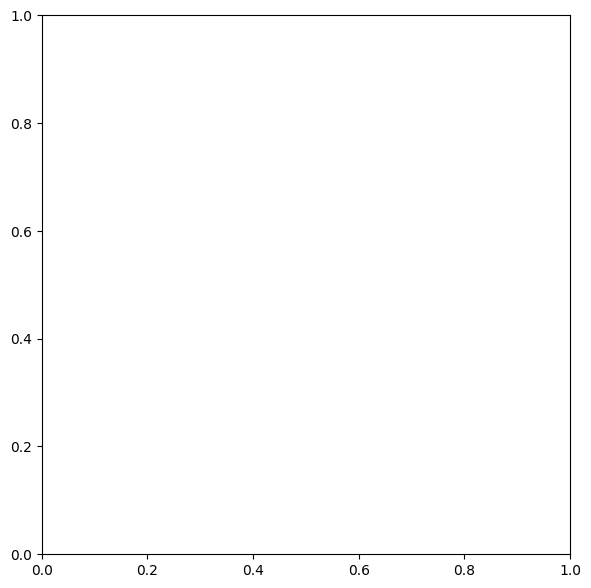

In [50]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_loss, test_loss, train_acc, test_acc):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(15, 7))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss", color='blue', marker='o')
    plt.plot(epochs, test_loss, label="Test Loss", color='red', marker='x')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy", color='green', marker='o')
    plt.plot(epochs, test_acc, label="Test Accuracy", color='orange', marker='x')
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_loss_curves(
    model_training_losses,
    model_testing_losses,
    model_training_accuracy,
    model_testing_accuracy
)


Your model fits the training data well but has unstable performance on the test set.

This instability may be due to:
* Small test set size (variance in performance across epochs).

* Overfitting: Model learns training patterns too well but fails to generalize.

* High learning rate: Causes oscillations in test performance.

* Data mismatch between training and testing sets.
